 A . . . . G
 . X . . T .
 . . H . . .
 . . . X . .
 . H . . . .
 . . . . . G

 →  →  →  →  →  G 
 ↑  X  →  →  ↑  ↑ 
 ↑  ↓  H  →  ↓  ← 
 ↓  →  ↓  X  ↓  ↓ 
 ↓  H  ↓  ↓  →  ↓ 
 →  →  →  →  →  G 



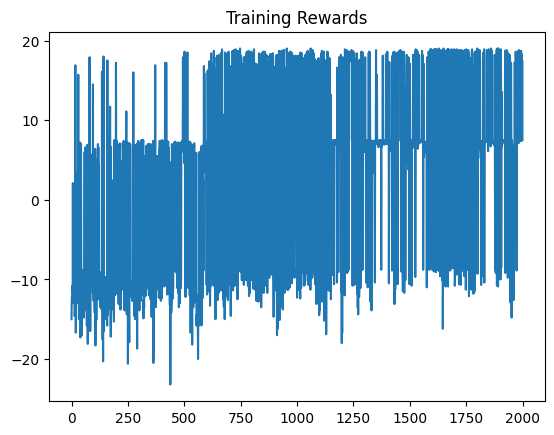

In [1]:

# Advanced Q-Learning implementation for a complex GridWorld
# - 6x6 gridworld with stochastic transitions and special tiles
# - Implements both standard and Double Q-Learning
# - Includes plotting, policy display, and saving Q-tables

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import math
import time

class ComplexGridWorld:
    def __init__(self, size=6, start=(0,0), slip_prob=0.15):
        self.size = size
        self.start = start
        self.agent_pos = start
        self.slip_prob = slip_prob
        self.action_space = 4
        self.state_space = size*size
        
        self.holes = {(2,2): -10, (4,1): -8}
        self.goals = {(5,5): 20, (0,5): 8}
        self.teleporters = {(1,4):(4,0)}
        self.obstacles = {(3,3), (1,1)}
        self.default_step_penalty = -0.1
        self.reward_map = {}
        for r in range(size):
            for c in range(size):
                if (r,c) in self.holes:
                    self.reward_map[(r,c)] = self.holes[(r,c)]
                elif (r,c) in self.goals:
                    self.reward_map[(r,c)] = self.goals[(r,c)]
                else:
                    self.reward_map[(r,c)] = 0.0
    
    def to_index(self, pos):
        return pos[0]*self.size + pos[1]
    def to_pos(self, idx):
        return (idx // self.size, idx % self.size)
    def reset(self):
        self.agent_pos = self.start
        return self.to_index(self.agent_pos)
    def in_bounds(self, r, c):
        return 0 <= r < self.size and 0 <= c < self.size
    def is_obstacle(self, r, c):
        return (r,c) in self.obstacles
    def step(self, action):
        if random.random() < self.slip_prob:
            action = random.choice(range(self.action_space))
        r, c = self.agent_pos
        if action == 0: r -= 1
        elif action == 1: c += 1
        elif action == 2: r += 1
        elif action == 3: c -= 1
        if not self.in_bounds(r,c) or self.is_obstacle(r,c):
            r, c = self.agent_pos
        new_pos = (r,c)
        if new_pos in self.teleporters:
            new_pos = self.teleporters[new_pos]
        self.agent_pos = new_pos
        reward = self.default_step_penalty + self.reward_map.get(new_pos, 0.0)
        done = new_pos in self.goals or new_pos in self.holes
        return self.to_index(new_pos), reward, done, {}
    def render(self):
        grid = [[" ." for _ in range(self.size)] for _ in range(self.size)]
        for (r,c), _ in self.goals.items():
            grid[r][c] = " G"
        for (r,c), _ in self.holes.items():
            grid[r][c] = " H"
        for (r,c) in self.obstacles:
            grid[r][c] = " X"
        for (r,c), dest in self.teleporters.items():
            grid[r][c] = " T"
        ar, ac = self.agent_pos
        grid[ar][ac] = " A"
        print("\n".join(["".join(row) for row in grid]))
        print()

def epsilon_greedy(Q, state, n_actions, epsilon):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    qvals = Q[state]
    maxv = max(qvals)
    max_actions = [i for i,a in enumerate(qvals) if a == maxv]
    return random.choice(max_actions)

def train_q_learning(env, episodes=2000, alpha=0.5, gamma=0.99, epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.999):
    Q = np.zeros((env.state_space, env.action_space))
    rewards = []
    epsilon = epsilon_start
    for ep in range(episodes):
        s = env.reset()
        total_r = 0.0
        done = False
        while not done:
            a = epsilon_greedy(Q, s, env.action_space, epsilon)
            ns, r, done, _ = env.step(a)
            Q[s,a] += alpha * (r + gamma*np.max(Q[ns]) - Q[s,a])
            s = ns
            total_r += r
        rewards.append(total_r)
        epsilon = max(epsilon_min, epsilon*epsilon_decay)
    return Q, rewards

def train_double_q_learning(env, episodes=2000, alpha=0.5, gamma=0.99, epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.999):
    Q1 = np.zeros((env.state_space, env.action_space))
    Q2 = np.zeros((env.state_space, env.action_space))
    rewards = []
    epsilon = epsilon_start
    for ep in range(episodes):
        s = env.reset()
        total_r = 0.0
        done = False
        while not done:
            if random.random() < epsilon:
                a = random.randrange(env.action_space)
            else:
                qsum = Q1[s] + Q2[s]
                a = np.argmax(qsum)
            ns, r, done, _ = env.step(a)
            if random.random() < 0.5:
                best_a = np.argmax(Q1[ns])
                Q1[s,a] += alpha*(r + gamma*Q2[ns,best_a] - Q1[s,a])
            else:
                best_a = np.argmax(Q2[ns])
                Q2[s,a] += alpha*(r + gamma*Q1[ns,best_a] - Q2[s,a])
            s = ns
            total_r += r
        rewards.append(total_r)
        epsilon = max(epsilon_min, epsilon*epsilon_decay)
    return Q1+Q2, Q1, Q2, rewards

def q_to_policy(Q, env):
    policy = np.argmax(Q, axis=1)
    return policy.reshape((env.size, env.size))

def print_policy(policy, env):
    mapper = {0:"↑",1:"→",2:"↓",3:"←"}
    for r in range(env.size):
        row = ""
        for c in range(env.size):
            if (r,c) in env.obstacles:
                row += " X "
            elif (r,c) in env.goals:
                row += " G "
            elif (r,c) in env.holes:
                row += " H "
            else:
                row += f" {mapper[policy[r,c]]} "
        print(row)
    print()

if __name__ == "__main__":
    env = ComplexGridWorld(size=6, start=(0,0), slip_prob=0.12)
    env.render()
    mode = "double"
    if mode == "q":
        Q, rewards = train_q_learning(env)
    else:
        Q, Q1, Q2, rewards = train_double_q_learning(env)
    policy = q_to_policy(Q, env)
    print_policy(policy, env)
    plt.plot(rewards)
    plt.title("Training Rewards")
    plt.show()
